### Imports

In [1]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_PI, max_UCB

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.metrics import mean_squared_error



### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

seed = 42
random.seed(seed)
np.random.seed(seed)

### Ideas
- perform feature selection before running model
- set the initial training set to be informative by choosing same 22 + 80 random as the authors

### Functions

In [2]:
def get_min_max_combinations(ranges_dict, feature):
    
    # min of all other features, max of this feature
    min_combo = []
    for key in ranges_dict.keys():
        
        if key == feature:
            min_combo.append(min(ranges_dict[key]))
        else:
            min_combo.append(max(ranges_dict[key]))
        

    # max of all other features, min of this feature
    max_combo = []
    for key in ranges_dict.keys():
        
        if key == feature:
            max_combo.append(max(ranges_dict[key]))
        else:
            max_combo.append(min(ranges_dict[key]))
    
    return tuple(min_combo), tuple(max_combo)

In [3]:
def get_index(df, combo):
    
    # split into components
    Mg_glutamate, K_glutamate, Amino_Acid, tRNA, coA, NAD, cAMP, Folinic_Acid, Spermidine, Three_PGA, NTP = combo
    
    # get index of matching row in data
    a = df.index[
              np.isclose(df['Mg-glutamate (mM)'], Mg_glutamate) \
            & np.isclose(df['K-glutamate (mM)'], K_glutamate) \
            & np.isclose(df['Amino Acid (mM)'], Amino_Acid) \
            & np.isclose(df['tRNA (mg/ml)'], tRNA) \
            & np.isclose(df['coA (mM)'],coA)  \
            & np.isclose(df['NAD (mM)'], NAD) \
            & np.isclose(df['cAMP (mM)'], cAMP) \
            & np.isclose(df['Folinic Acid (mM)'], Folinic_Acid) \
            & np.isclose(df['Spermidine (mM)'], Spermidine) \
            & np.isclose(df['3-PGA (mM)'], Three_PGA) \
            & np.isclose(df['NTP (mM)'], NTP)]
    return a.tolist()[0]



In [4]:
def get_initial_22_idx(df, ranges_dict):
    
    initial_idx = []
    
    # for each feature
    for key in ranges_dict.keys():
        min_combo, max_combo = get_min_max_combinations(ranges_dict,key)
        idx = get_index(df, min_combo)
        initial_idx.append(idx)
        idx = get_index(df, max_combo)
        initial_idx.append(idx)
        
    return np.array(initial_idx)
    

# Build Bayesian Optimizer
- with Gaussian process
- define the sample space as the data pool. this is an ad-hoc version of membership query synthesis, because we can't draw from any possible point, only the points we have values for.

**Hint: Check the modAL [documentation](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html#Optimizing-using-expected-improvement) for how to set up a Baysian optimizer.**

In [5]:
def get_next_sample(optimizer, X_pool, y_pool):

    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = optimizer.query(X_pool)

    # modify indexing to interpret as collection of one element with d features
    query_sample_reshaped = query_sample.reshape(1, -1)

    # obtain the query label
    query_label = y_pool[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1, )

    return query_sample_reshaped, query_label_reshaped, query_idx


In [6]:
def get_next_batch(optimizer, X_pool, y_pool, batch_size):
    
    n_col = X_pool.shape[1]
    X_batch = np.zeros((batch_size, n_col))
    y_batch = np.zeros((batch_size,))

    
    for i in range(batch_size):
        
        X_sample, y_sample, query_idx = get_next_sample(optimizer, X_pool, y_pool)
        
        # add to batch
        X_batch[i] = X_sample
        y_batch[i] = y_sample
        
        # remove queried point from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)     
        
    return X_batch, y_batch, X_pool, y_pool
        


In [7]:
def score_regression_model(optimizer, X_test, y_test, X_train, y_train):

    y_pred = optimizer.predict(X_test, return_std=False)
    r2 = r2_score(y_test, y_pred)
    
    # root square mean error
    # test data
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    
    # training data
    y_pred_train = optimizer.predict(X_train, return_std=False)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    
    return r2, rmse_test, rmse_train

In [8]:
def run_bayesian_optimization(optimizer, X_pool, y_pool, n_batch, batch_size, initial):
    print('X_pool size, y_pool size', X_pool.shape, y_pool.shape)
    selected = [initial]
    data_sets = [(X_pool,y_pool)]
    for b in range(n_batch):
        
        # get next set of points to learn
        X_batch, y_batch, X_pool, y_pool = get_next_batch(optimizer, X_pool, y_pool, batch_size)
        print('X_pool size, y_pool size', X_pool.shape, y_pool.shape)
        
        # save data
        batch_col = np.array([b]*len(X_batch)).reshape(-1,1)
        y_col = y_batch.reshape(-1,1)
        result = np.append(X_batch,y_col, axis=1)
        selected.append(result)
        
        # save dataset
        data_sets.append((X_pool,y_pool))
    
        # use new sample to update the model
        optimizer.teach(X_batch, y_batch)
    
    return selected,data_sets

In [9]:
def build_results_dataframe(selected, cols):
    
    # empty dataframe with correct column number
    df = pd.DataFrame(columns=cols)
    
    for i,each in enumerate(selected):
        
        # create rows
        df_i = pd.DataFrame(each, columns=cols)
        
        # add col for batch
        df_i['Batch'] = i
        
        # append to final dataframe
        df = df.append(df_i)
        
    return df
        

In [10]:
def yield_stats(df, batch):
    """
    Average yield and min and max yield.
    """
    
    df_yield = df[df['Batch']==batch]['Yield']
    
    # mean
    mean_yield = df_yield.mean()
    
    # std dev
    std_yield = df_yield.std()
    
    # min
    min_yield = df_yield.min()
    
    # max
    max_yield = df_yield.max()
    
    # max
    median_yield = df_yield.median()
    
    return mean_yield, std_yield, min_yield, max_yield, median_yield
    

# Data Prep

### Load Data

In [11]:
data = pd.read_csv('data/DataPool.csv')
print(data.shape)
data.head(5)
cols = data.columns

(1017, 12)


### Split into features and target

In [12]:
X = data.drop(['Yield'],axis=1)
print(X.shape)
y_pool = data['Yield'].to_numpy()
print(y_pool.shape)

(1017, 11)
(1017,)


### Scale data
So all variables have the same mean and std dev

In [13]:
scaler = StandardScaler()
X_pool = scaler.fit_transform(X)

# Define initial dataset
- 11 data points in which each compound is minimized except one is maximized
- 11 data pionts in which each compound is maximized except one is minimized
- 80 random data points

In [14]:
ranges_dict = {
    'Mg-glutamate (mM)':[0.4,1.2,2,4],
    'K-glutamate (mM)':[8,24,40,80],
    'Amino Acid (mM)': [0.15,0.45,0.75,1.5],
    'tRNA (mg/ml)':[0.02,0.06,0.1,0.2],
    'coA (mM)':[0.026,0.078,0.13,0.26],
    'NAD (mM)':[0.033,0.099,0.165,0.33],
    'cAMP (mM)':[0.075,0.225,0.375,0.75],
    'Folinic Acid (mM)':[0.0068,0.0204,0.034,0.068],
    'Spermidine (mM)':[0.1,0.3,0.5,1],
    '3-PGA (mM)':[3,9,15,30],
    'NTP (mM)':[0.15,0.45,0.75,1.5]
}


In [15]:
def get_random_n_idx(y_pool, y_max, n):
    
    selected_idx = []
    while len(selected_idx) < n:
        idx = np.random.choice(range(len(X_pool)), size=1, replace=False)
        
        if idx not in selected_idx: # hasn't been selected yet
            
            # limit max yield to y_max 
            if y_pool[idx] <= y_max:
                selected_idx.append(idx.item(0))
                
    return selected_idx

In [16]:
idx_first_22 = get_initial_22_idx(data, ranges_dict)

X_training_22 = X_pool[idx_first_22]
y_training_22 = y_pool[idx_first_22]
print(X_training_22.shape)
print(y_training_22.shape)

# remove from pool
X_pool = np.delete(X_pool, idx_first_22, axis=0)
y_pool = np.delete(y_pool, idx_first_22)   
print(X_pool.shape)
print(y_pool.shape)

# # chose 80 points from pool at random
# idx_random_80 = np.random.choice(range(len(X_pool)), size=80, replace=False)

# choose 80 points at random, with the limitation that the yield should not exceed that of the initial 22
y_max = np.max(y_training_22)
idx_random_80 = get_random_n_idx(y_pool, y_max, n=80)
X_training_80, y_training_80 = X_pool[idx_random_80], y_pool[idx_random_80]
print(X_training_80.shape)
print(y_training_80.shape)


# remove 80 points from pool
X_pool = np.delete(X_pool, idx_random_80, axis=0)
y_pool = np.delete(y_pool, idx_random_80)   
print(X_pool.shape)
print(y_pool.shape) 

# combine training sets together
X_training = np.append(X_training_22, X_training_80, axis=0)
y_training = np.append(y_training_22, y_training_80, axis=0)
print(X_training.shape)
print(y_training.shape)

assert X_training.shape == (102,11)
assert y_training.shape == (102, )

(22, 11)
(22,)
(995, 11)
(995,)
(80, 11)
(80,)
(915, 11)
(915,)
(102, 11)
(102,)


# Run model
Does initial training set count among total query number of 510? Yes
- random initial training set
- try other kernels
- bootstrap initial training set around 1.0 only (or 22 range)

(915, 11)
(915,)
X_pool size, y_pool size (915, 11) (915,)
X_pool size, y_pool size (813, 11) (813,)
X_pool size, y_pool size (711, 11) (711,)
X_pool size, y_pool size (609, 11) (609,)
X_pool size, y_pool size (507, 11) (507,)


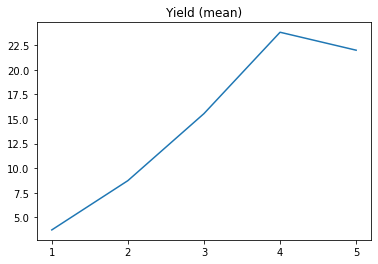

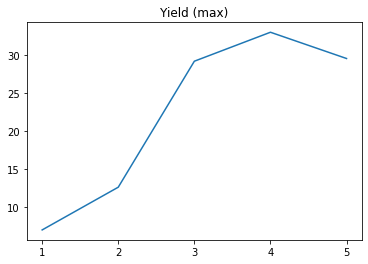

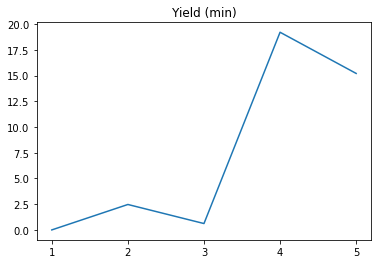

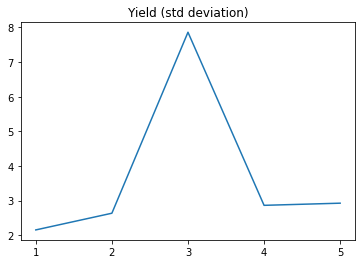

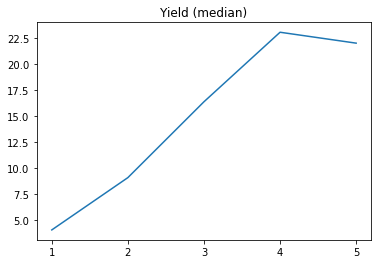

CPU times: user 15.1 s, sys: 350 ms, total: 15.5 s
Wall time: 4.21 s


In [17]:
%%time 

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)
print(X_cp.shape)
print(y_cp.shape)

# define optimizer
# Matern(1.0)
kernel = Matern(4) 
optimizer = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=kernel),
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# save initial training data as first batch
initial = np.append(X_training, y_training.reshape(-1,1),axis=1)

# Bayesian optimization
n_batch = 4
batch_size = 102
selected, data_sets = run_bayesian_optimization(optimizer, X_cp, y_cp, n_batch, batch_size, initial)


df_results = build_results_dataframe(selected, cols.tolist())

mean_yields = [] 
std_yields = []
min_yields = []
max_yields = []
median_yields = []

for b in range(n_batch+1):
    mean_yield, std_yield, min_yield, max_yield, median_yield = yield_stats(df_results, b)
    
    mean_yields.append(mean_yield)
    std_yields.append(std_yield)
    min_yields.append(min_yield)
    max_yields.append(max_yield)
    median_yields.append(median_yield)
    
plt.title('Yield (mean)')
plt.xticks([1,2,3,4,5])
plt.plot([1,2,3,4,5], mean_yields)
plt.show()

plt.title('Yield (max)')
plt.xticks([1,2,3,4,5])
plt.plot([1,2,3,4,5],max_yields)
plt.show()

plt.title('Yield (min)')
plt.xticks([1,2,3,4,5])
plt.plot([1,2,3,4,5],min_yields)
plt.show()


plt.title('Yield (std deviation)')
plt.xticks([1,2,3,4,5])
plt.plot([1,2,3,4,5],std_yields)
plt.show()

plt.title('Yield (median)')
plt.xticks([1,2,3,4,5])
plt.plot([1,2,3,4,5],median_yields)
plt.show()


In [18]:
# median yield after 5 rounds
median_yields

[4.0805, 9.1115, 16.406999999999996, 23.092, 22.043]

# Results
- Selected points
- how do they define how much yield has improved? what is the starting yield?
- notice how my 80 random points are much better on average because I only select from best 1017 so far

In [19]:
def plot_points(df_results, n_batch, batch_size, spread):
    x_points = []
    
    x_dist = spread / batch_size  # distance to next point
    
    for b in range(1,n_batch+1):  # shift points by 1
        
        x0 = b - spread/2  # starting x position for this batch
        
        for i in range(batch_size):

            xi = x0 + i*x_dist  # x value to position the ith yield in this batch
            x_points.append(xi)
            
    return x_points

In [20]:
len(data_sets)


5

### Plot Results

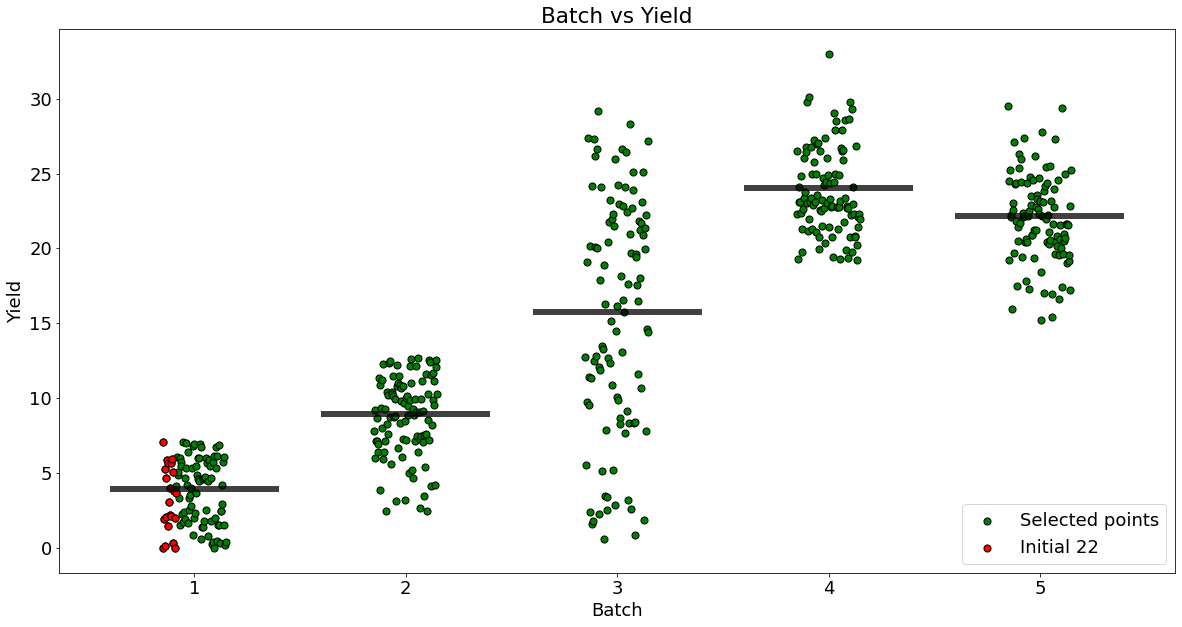

In [21]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))


# plot selected points
x_points = plot_points(df_results, n_batch+1, batch_size, 0.3)
len(x_points)

plt.scatter(x_points, 
            df_results['Yield'].tolist(),
            marker="o",
            s=50,
            color='g',
           edgecolor='k',
           label='Selected points')

plt.scatter(x_points[:22], 
            df_results['Yield'].tolist()[:22],
            marker="o",
            s=50,
            color='r',
           edgecolor='k',
           label='Initial 22')


plt.bar([1,2,3,4,5], 
        height=0.4,  
        bottom=mean_yields,
        alpha=0.75,
       color='k')
plt.title('Batch vs Yield')
plt.ylabel('Yield')
plt.xlabel('Batch')
plt.legend(loc='lower right')
plt.show()

### Plot results with pool

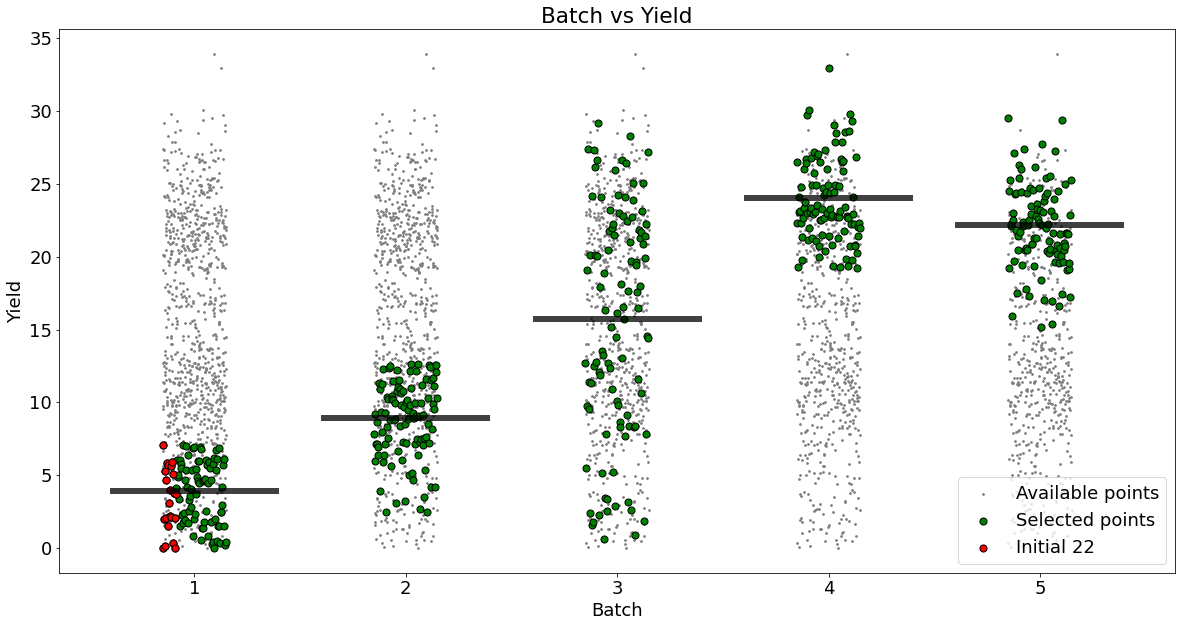

In [22]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))

# plot points remaining at each step
# batch 1
X_batch, y_batch = data_sets[0]
n_y_0 = len(y_batch)
x_points_2 = plot_points(df_results, 1, n_y_0, 0.3)[n_y_0*0:]
plt.scatter(x_points_2, 
            y_batch,
            marker="o",
            s=3,
            color='gray',
           label='Available points')

# batch 2
X_batch, y_batch = data_sets[1]
n_y_1 = len(y_batch)
x_points_2 = plot_points(df_results, 2, n_y_1, 0.3)[n_y_1*1:]
plt.scatter(x_points_2, 
            y_batch,
            marker="o",
            s=3,
            color='gray')

# batch 3
X_batch, y_batch = data_sets[2]
n_y_2 = len(y_batch)
x_points_2 = plot_points(df_results, 3, n_y_2, 0.3)[n_y_2*2:]
plt.scatter(x_points_2, 
            y_batch,
            marker="o",
            s=3,
            color='gray')

# batch 3
X_batch, y_batch = data_sets[3]
n_y_3 = len(y_batch)
x_points_2 = plot_points(df_results, 4, n_y_3, 0.3)[n_y_3*3:]
plt.scatter(x_points_2, 
            y_batch,
            marker="o",
            s=3,
            color='gray')


# batch 4
X_batch, y_batch = data_sets[4]
n_y_4 = len(y_batch)
x_points_2 = plot_points(df_results, 5, n_y_4, 0.3)[n_y_4*4:]
plt.scatter(x_points_2, 
            y_batch,
            marker="o",
            s=3,
            color='gray')



# plot selected points
x_points = plot_points(df_results, n_batch+1, batch_size, 0.3)
len(x_points)

plt.scatter(x_points, 
            df_results['Yield'].tolist(),
            marker="o",
            s=50,
            color='g',
           edgecolor='k',
           label='Selected points')

plt.scatter(x_points[:22], 
            df_results['Yield'].tolist()[:22],
            marker="o",
            s=50,
            color='r',
           edgecolor='k',
           label='Initial 22')


plt.bar([1,2,3,4,5], 
        height=0.4,  
        bottom=mean_yields,
        alpha=0.75,
       color='k')
plt.title('Batch vs Yield')
plt.ylabel('Yield')
plt.xlabel('Batch')
plt.legend(loc='lower right')
plt.show()

In [23]:
# determine max yield
optimizer.get_max()

(array([ 0.94676264,  0.92313613,  1.83091303,  0.42277081, -0.79261071,
        -0.17536166, -0.5332725 ,  0.38630903, -0.69660128, -0.2517081 ,
         0.93357079]),
 32.983000000000004)

# Score model

In [24]:
def run_kfold_bayesian_optimization(X_pool, y_pool, X_training, y_training, n_batch, batch_size, k, seed):
    """
    Return K x n_batch matrix, where M[k][b] is the r2 score of the bth batch in the kth fold.
    """
    
    # define folds
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    kf.get_n_splits(X_pool)
    print(kf)
     
    # save r2 score for all folds
    r2_scores_all = []
    rmse_scores_all = []
    
    # for each fold
    for train_index, test_index in kf.split(X_pool):
        
        # define optimizer for this fold
        kernel = Matern(1.0) 
        optimizer = BayesianOptimizer(
            estimator=GaussianProcessRegressor(kernel=kernel),
            X_training=X_training, 
            y_training=y_training,
            query_strategy=max_EI
        )
        
        # define data for this fold
        X_train, X_test = X_pool[train_index], X_pool[test_index]
        y_train, y_test = y_pool[train_index], y_pool[test_index]
        
        # save r2 score for kth batch
        r2_scores_k = []
        rmse_scores_k = []
        
        # initial score for model
        r2, rmse_test, rmse_train = score_regression_model(optimizer, 
                                                           X_test, 
                                                           y_test, 
                                                           optimizer.X_training, 
                                                           optimizer.y_training)
        r2_scores_k.append(r2)
        rmse_scores_k.append((rmse_test, rmse_train))
        
        # for each batch
        for b in range(n_batch):
        
            # get next set of points to learn
            X_batch, y_batch, X_train, y_train = get_next_batch(optimizer, X_train, y_train, batch_size)
#             print('X_train size, y_train size', X_train.shape, y_train.shape)

            # use new sample to update the model
            optimizer.teach(X_batch, y_batch)
            
            # score model after training
            r2, rmse_test, rmse_train = score_regression_model(optimizer, 
                                                           X_test, 
                                                           y_test, 
                                                           optimizer.X_training, 
                                                           optimizer.y_training)
            r2_scores_k.append(r2)
            rmse_scores_k.append((rmse_test, rmse_train))
    
        # save scores for this fold
        r2_scores_all.append(r2_scores_k)
        rmse_scores_all.append(rmse_scores_k)
        
    return r2_scores_all,rmse_scores_all
    

In [25]:
def get_score_stats(scores_arr):
    
    # stats 
    batch_mean = np.mean(scores_arr,axis=0)
    batch_std = np.std(scores_arr,axis=0)
        
    return batch_mean, batch_std

### Get Scores

In [26]:
%%time

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)
print(X_cp.shape)
print(y_cp.shape)


# Bayesian optimization
n_batch = 4
batch_size = 102
k = 5
r2_scores, rmse_scores = run_kfold_bayesian_optimization(X_cp, 
                                                         y_cp, 
                                                         X_training, 
                                                         y_training, 
                                                         n_batch, 
                                                         batch_size, 
                                                         k, 
                                                         seed)
len(r2_scores)


(915, 11)
(915,)
KFold(n_splits=5, random_state=42, shuffle=True)
CPU times: user 48.2 s, sys: 517 ms, total: 48.7 s
Wall time: 12.3 s


5

In [27]:
r2_scores_arr = np.array(r2_scores)
r2_scores_arr

array([[-2.71161086, -2.80270929, -2.71407937, -3.23314718, -1.11373322],
       [-4.0184723 , -4.16719892, -4.09483832, -4.3235942 , -2.49511231],
       [-2.74444556, -2.8389671 , -2.71016323, -2.13776221, -0.67352384],
       [-3.1147074 , -3.24769229, -3.10679945, -2.62589908, -1.21985296],
       [-3.04979907, -3.15741156, -3.07896381, -2.67379888, -0.86190279]])

In [28]:
r2_scores_y = np.array([i+1 for i in range(n_batch+1)]*(n_batch+1))

r2_scores_combined = np.append(r2_scores_y.reshape(-1,1),r2_scores_arr.reshape(-1,1),  axis=1)
r2_scores_combined


array([[ 1.        , -2.71161086],
       [ 2.        , -2.80270929],
       [ 3.        , -2.71407937],
       [ 4.        , -3.23314718],
       [ 5.        , -1.11373322],
       [ 1.        , -4.0184723 ],
       [ 2.        , -4.16719892],
       [ 3.        , -4.09483832],
       [ 4.        , -4.3235942 ],
       [ 5.        , -2.49511231],
       [ 1.        , -2.74444556],
       [ 2.        , -2.8389671 ],
       [ 3.        , -2.71016323],
       [ 4.        , -2.13776221],
       [ 5.        , -0.67352384],
       [ 1.        , -3.1147074 ],
       [ 2.        , -3.24769229],
       [ 3.        , -3.10679945],
       [ 4.        , -2.62589908],
       [ 5.        , -1.21985296],
       [ 1.        , -3.04979907],
       [ 2.        , -3.15741156],
       [ 3.        , -3.07896381],
       [ 4.        , -2.67379888],
       [ 5.        , -0.86190279]])

### Get stats

In [29]:
r2_batch_mean, r2_batch_std = get_score_stats(r2_scores_arr)
r2_batch_mean

array([-3.12780704, -3.24279583, -3.14096884, -2.99884031, -1.27282503])

### Plot stats per batch
- use same initial training set here? sure
- use 5-fold cross validation like the authors? sure

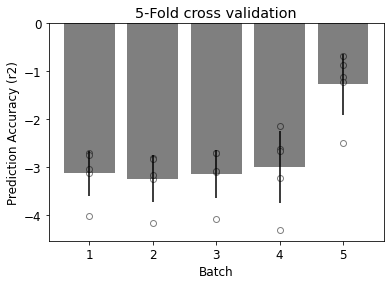

In [30]:

plt.rcParams.update({'font.size': 12})
# plt.figure(figsize=(20,10))
plt.scatter(r2_scores_combined[:,0],r2_scores_combined[:,1], marker='o', color='w',edgecolor='gray')

plt.bar([1,2,3,4,5], 
        height=r2_batch_mean, 
        yerr=r2_batch_std,
        alpha=0.5,
       color='k')

plt.title('5-Fold cross validation')
plt.ylabel('Prediction Accuracy (r2)')
plt.xlabel('Batch')
# plt.legend()
plt.show()

### RMSE
Test error

In [31]:
# compare rmse for test, train after 5 batches
rsme_test_all = []
rsme_train_all = []
for rsme_test, rsme_train in rmse_scores[4]:
    rsme_test_all.append(rsme_test)
    rsme_train_all.append(rsme_train)
    
print('rsme test:', np.array([rsme_test_all]).mean())
print('rsme train:', np.array([rsme_train_all]).mean())

rsme test: 13.990240647564741
rsme train: 0.02972665309017248
